In [16]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt

import os
import sys
import pore_c_utils as pcu
from importlib import reload

In [2]:
resolution = 1000000 # 1MB

In [17]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

In [3]:
# load pore data coolers 
scPoreCfilepath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/matrix/"

cellNums = [1, 2, 4, 5, 6, 7] # dropping cell 3 due to sparsity
filetags = [f"run0{x}" for x in cellNums]

poreC = {}

for cell in filetags:
    
    fullPath = f"{scPoreCfilepath}NlaIII_{cell}_GRCm39_unphased.matrix.mcool"
    clr = cooler.Cooler(f'{fullPath}::resolutions/{resolution}')
    
    poreC[cell] = clr
    
poreC.keys()

dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])

In [36]:
poreCclr = poreC['run01']

chromRegions = {}

for i in poreCclr.chromnames:
    if 'NC' in i:
        extent = poreCclr.extent(i)
        chromRegions[i] = extent
    
print(f"{len(chromRegions)=}")
print(chromRegions)

len(chromRegions)=22
{'NC_000067.7': (0, 196), 'NC_000068.8': (202, 384), 'NC_000069.7': (384, 544), 'NC_000070.7': (544, 701), 'NC_000071.7': (702, 854), 'NC_000072.7': (859, 1009), 'NC_000073.7': (1009, 1154), 'NC_000074.7': (1155, 1286), 'NC_000075.7': (1286, 1411), 'NC_000076.7': (1411, 1542), 'NC_000077.7': (1542, 1664), 'NC_000078.7': (1664, 1785), 'NC_000079.7': (1785, 1906), 'NC_000080.7': (1906, 2032), 'NC_000081.7': (2032, 2137), 'NC_000082.7': (2137, 2236), 'NC_000083.7': (2236, 2332), 'NC_000084.7': (2332, 2423), 'NC_000085.7': (2423, 2485), 'NC_000086.8': (2485, 2655), 'NC_000087.8': (2656, 2748), 'NC_005089.1': (2773, 2774)}


In [53]:
chromIndices = []

for k, v in chromRegions.items():
    binRange = list(np.arange(v[0], v[1]))
    chromIndices += binRange
    
chromIndices = np.array(chromIndices, dtype=int)
len(chromIndices)

2735

In [5]:
scHICfilepath = f"/nfs/turbo/umms-indikar/shared/projects/poreC/nagano_2017_data/nagano_1MB_raw_BALANCED.scool"
cellList = list(cooler.fileops.list_coolers(scHICfilepath))

sampleSize = len(poreC) # sample 6 randomly
sample = np.random.choice(cellList, sampleSize, replace=False)

hiC = {}

for s in sample:
    filetag = "_".join(s.split("_")[0:2]).replace("/", "")

    clr = cooler.Cooler(f"{scHICfilepath}::{s}")
    
    hiC[filetag] = clr
    
hiC.keys()

dict_keys(['Diploid_10', 'Diploid_13', 'Diploid_9', 'Diploid_31', 'Diploid_32', 'Diploid_34'])

In [6]:
hiCclr = hiC[filetag]

for i in hiCclr.chromnames:
    print(f'{i} : {hiCclr.extent(i)}')

chr10 : (0, 130)
chr11 : (130, 252)
chr12 : (252, 374)
chr13 : (374, 495)
chr13_random : (495, 496)
chr14 : (496, 622)
chr15 : (622, 726)
chr16 : (726, 825)
chr16_random : (825, 826)
chr17 : (826, 922)
chr17_random : (922, 923)
chr18 : (923, 1014)
chr19 : (1014, 1076)
chr1 : (1076, 1274)
chr1_random : (1274, 1276)
chr2 : (1276, 1458)
chr3 : (1458, 1618)
chr3_random : (1618, 1619)
chr4 : (1619, 1775)
chr4_random : (1775, 1776)
chr5 : (1776, 1929)
chr5_random : (1929, 1930)
chr6 : (1930, 2080)
chr7 : (2080, 2233)
chr7_random : (2233, 2234)
chr8 : (2234, 2366)
chr8_random : (2366, 2367)
chr9 : (2367, 2492)
chr9_random : (2492, 2493)
chrM : (2493, 2494)
chrUn_random : (2494, 2500)
chrX : (2500, 2667)
chrX_random : (2667, 2669)
chrY : (2669, 2685)
chrY_random : (2685, 2744)


In [57]:
zippedKeys = list(zip(poreC.keys(), hiC.keys()))


for pKey, hKey in zippedKeys:
    print("------------------------")
    print(f"{pKey=}")
    print(f"{hKey=}")
    
    pMat = poreC[pKey].matrix(balance=True)[:]
#     hMat = hiC[hKey].matrix(balance=True)[:]
    
    print(f"{pMat.shape}")
    
    test = pMat[chromIndices ; chromIndices]
    print(f"{test.shape}")
    
#     print(f"{hMat.shape}")
    
    break
    

SyntaxError: invalid syntax (<ipython-input-57-4a27f23d1141>, line 14)

In [7]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 10

zippedKeys = list(zip(poreC.keys(), hiC.keys()))

for pKey, hKey in zippedKeys:
    
    print("------------------------")
    print(f"{pKey=}")
    print(f"{hKey=}")
    pMat = poreC[pKey].matrix(balance=True)[:]
    hMat = hiC[hKey].matrix(balance=True)[:]
    
    # binarize both
    pMatBinary = np.where(pMat > 0, 1, 0)
    hMatBinary = np.where(hMat > 0, 1, 0)
    
    
    sumPoreC = np.triu(pMatBinary).sum()
    sumPoreCDiag = np.diag(pMatBinary).sum()
    
    sumhiC = np.triu(hMatBinary).sum()
    sumhiCDiag = np.diag(hMatBinary).sum()
    
    print()
    print(f"{sumPoreC=}")
    print(f"{sumPoreCDiag=}")
    print(f"{sumPoreCDiag/sumPoreC=:.3f}")
    
    print()
    print(f"{sumhiC=}")
    print(f"{sumhiCDiag=}")
    print(f"{sumhiCDiag/sumPoreC=:.3f}")
    

#     fig, ax = plt.subplots(1, 2) 
    
#     ax[0].matshow(pMatBinary, cmap='binary')
#     ax[0].set_title(f'scPore-C Contacts: {pKey}', y=1.2)

#     ax[1].matshow(hMatBinary, cmap='binary')
#     ax[1].set_title(f'scHi-C Contacts: {hKey}', y=1.2)
    
#     plt.show()
    

------------------------
pKey='run01'
hKey='Diploid_10'

sumPoreC=104677
sumPoreCDiag=2602
sumPoreCDiag/sumPoreC=0.025

sumhiC=27138
sumhiCDiag=2572
sumhiCDiag/sumPoreC=0.025
------------------------
pKey='run02'
hKey='Diploid_13'

sumPoreC=95901
sumPoreCDiag=2463
sumPoreCDiag/sumPoreC=0.026

sumhiC=23713
sumhiCDiag=2565
sumhiCDiag/sumPoreC=0.027
------------------------
pKey='run04'
hKey='Diploid_9'

sumPoreC=131480
sumPoreCDiag=2607
sumPoreCDiag/sumPoreC=0.020

sumhiC=29078
sumhiCDiag=2579
sumhiCDiag/sumPoreC=0.020
------------------------
pKey='run05'
hKey='Diploid_31'

sumPoreC=103914
sumPoreCDiag=2599
sumPoreCDiag/sumPoreC=0.025

sumhiC=15891
sumhiCDiag=2566
sumhiCDiag/sumPoreC=0.025
------------------------
pKey='run06'
hKey='Diploid_32'

sumPoreC=137672
sumPoreCDiag=2605
sumPoreCDiag/sumPoreC=0.019

sumhiC=36834
sumhiCDiag=2579
sumhiCDiag/sumPoreC=0.019
------------------------
pKey='run07'
hKey='Diploid_34'

sumPoreC=283126
sumPoreCDiag=2611
sumPoreCDiag/sumPoreC=0.009

sumhiC=

------------------------
pKey='run01'
hKey='Diploid_10'


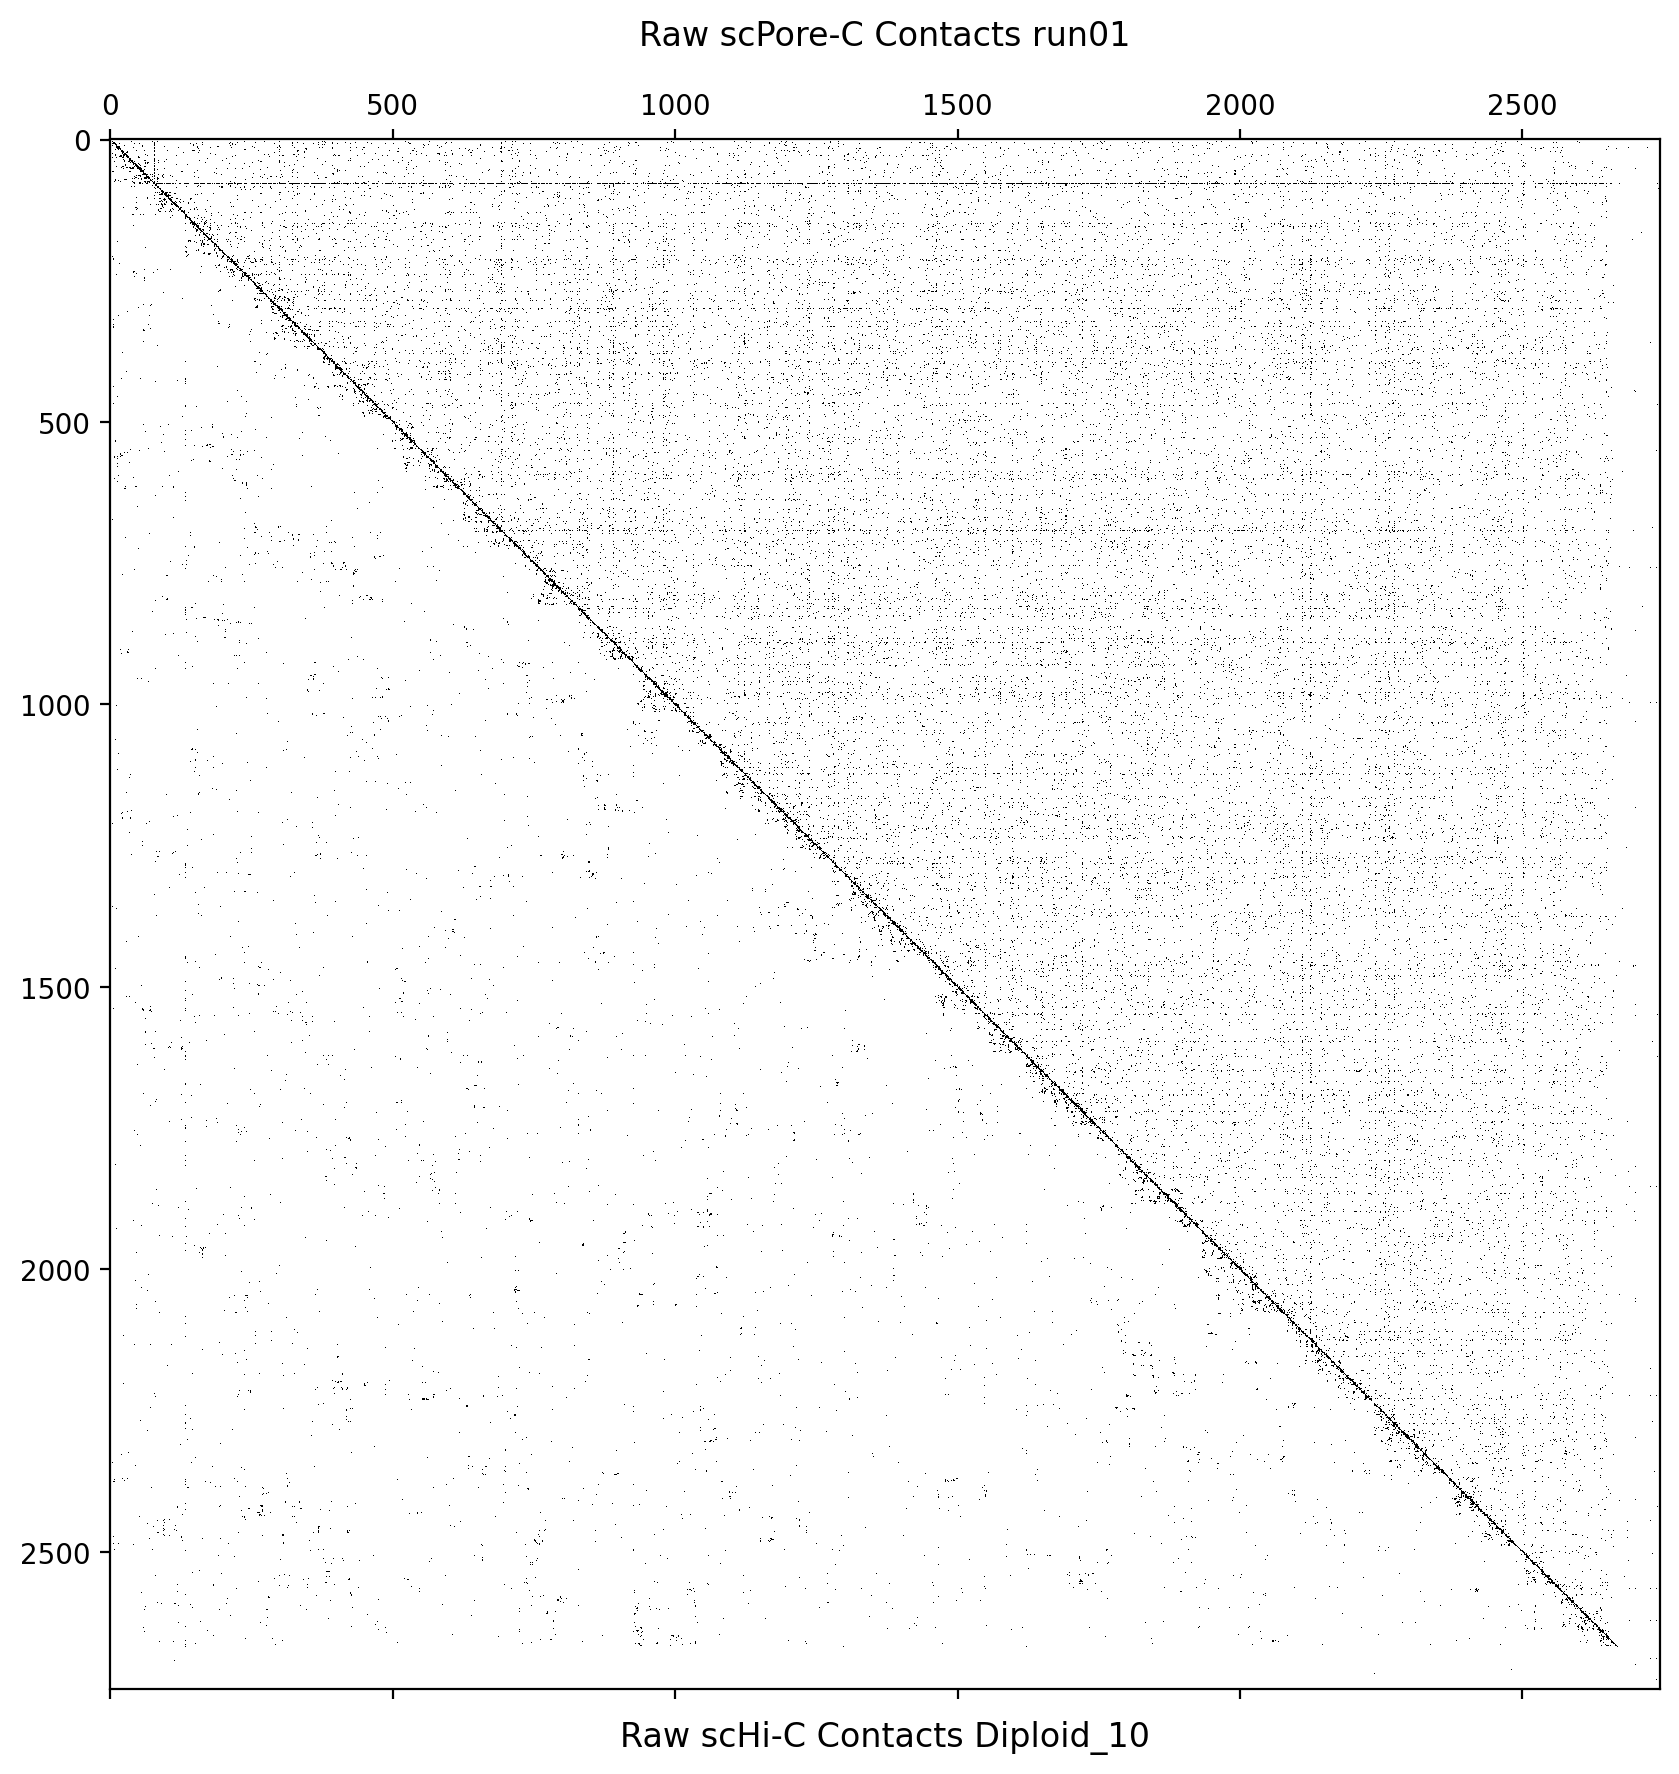

------------------------
pKey='run02'
hKey='Diploid_13'


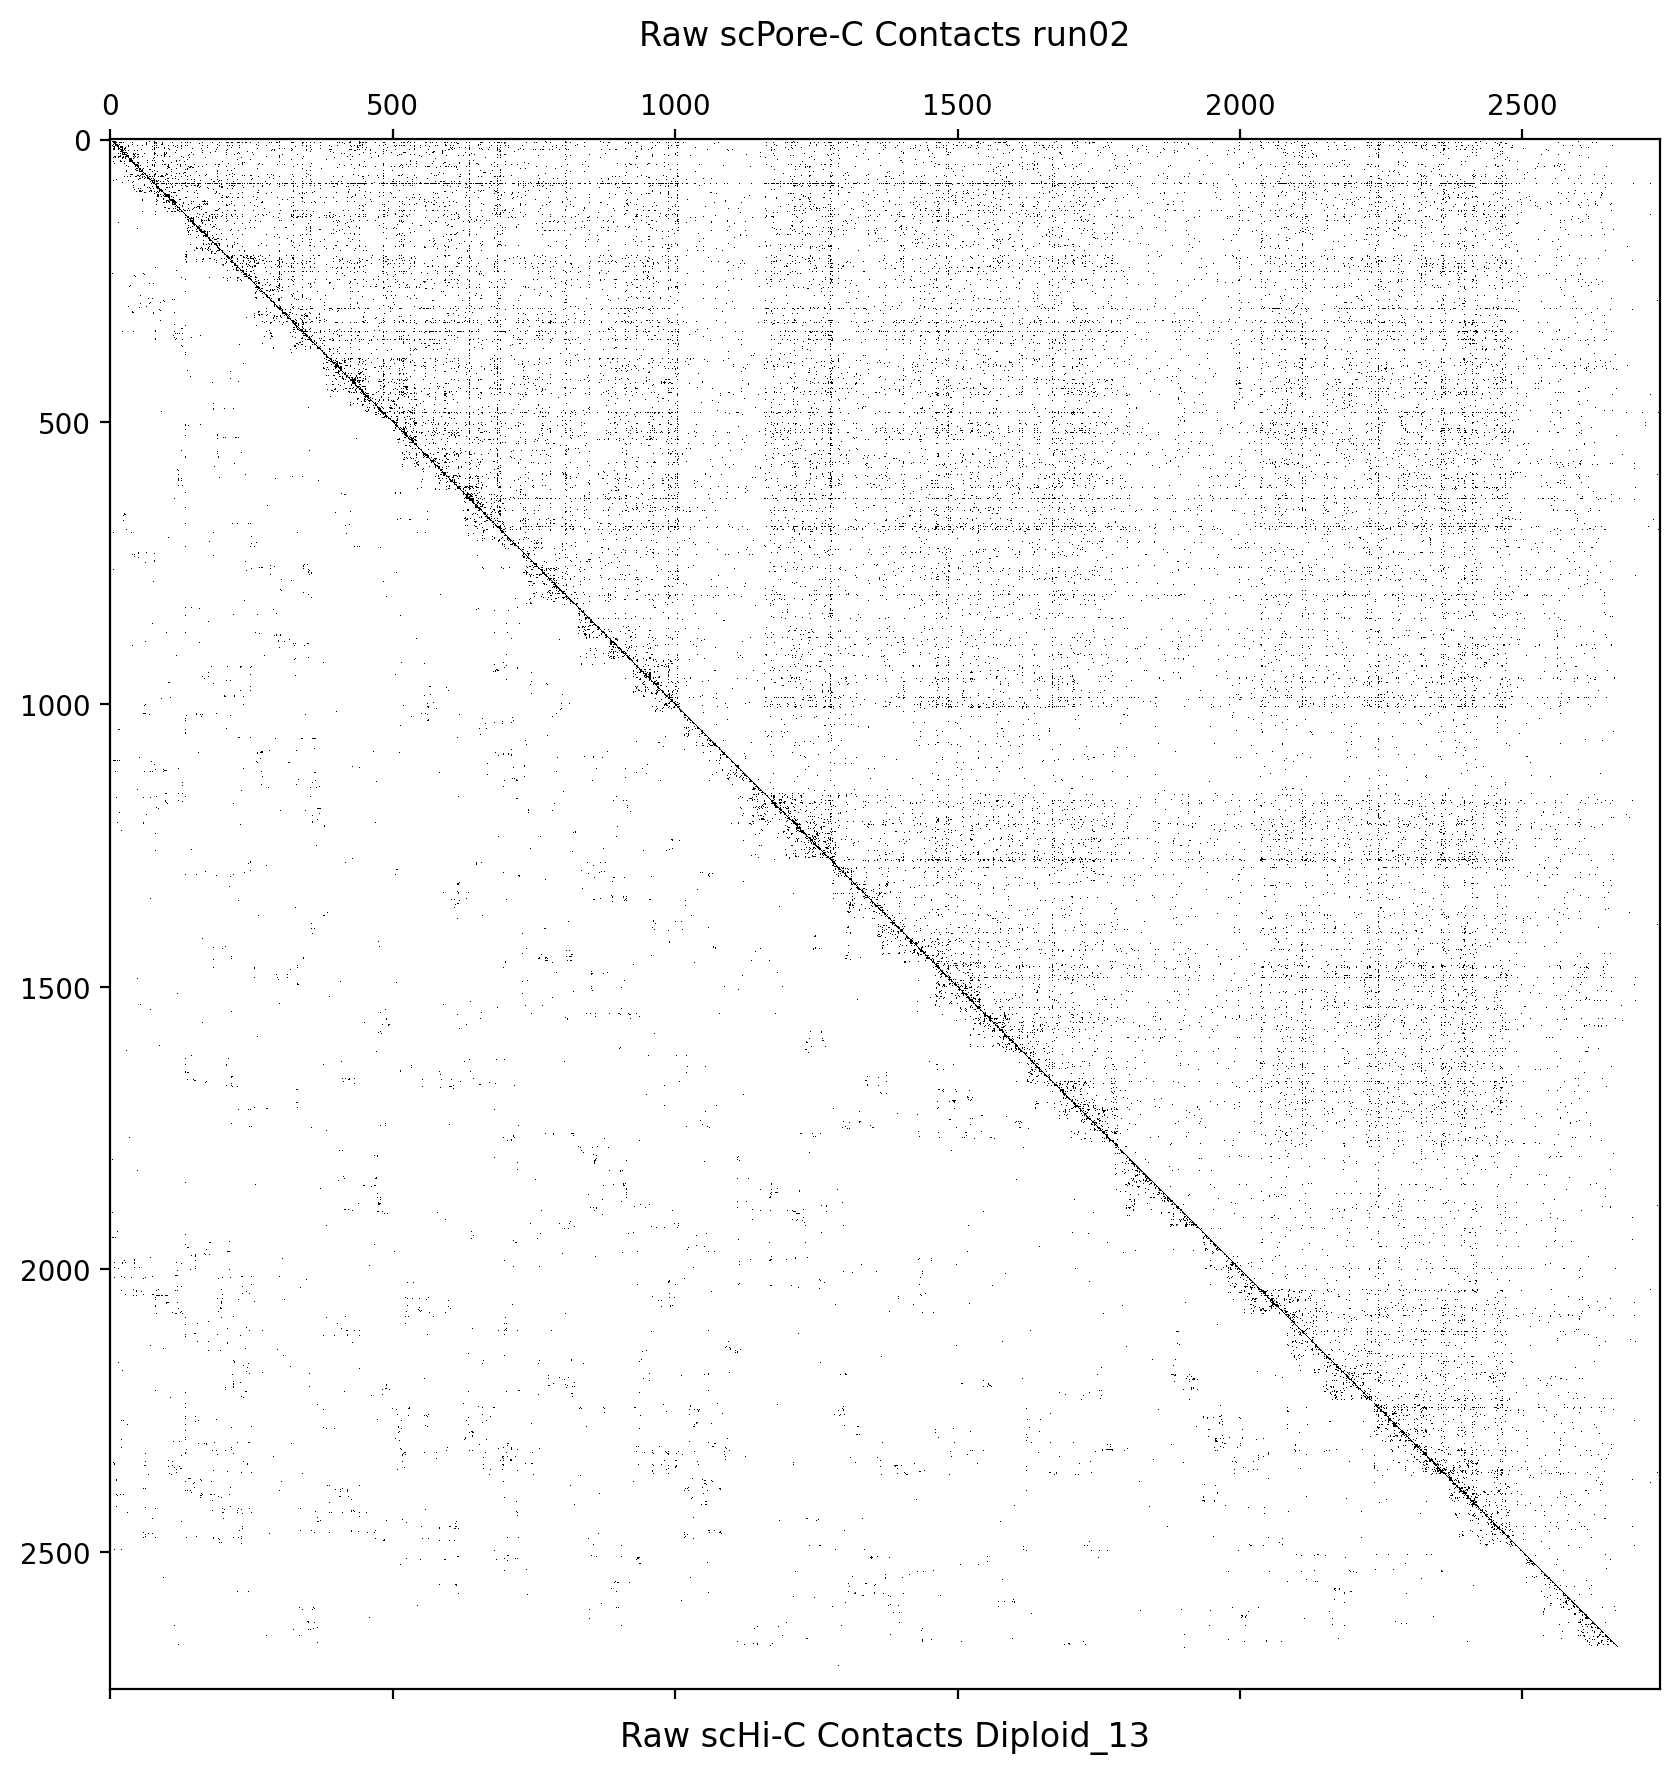

------------------------
pKey='run04'
hKey='Diploid_9'


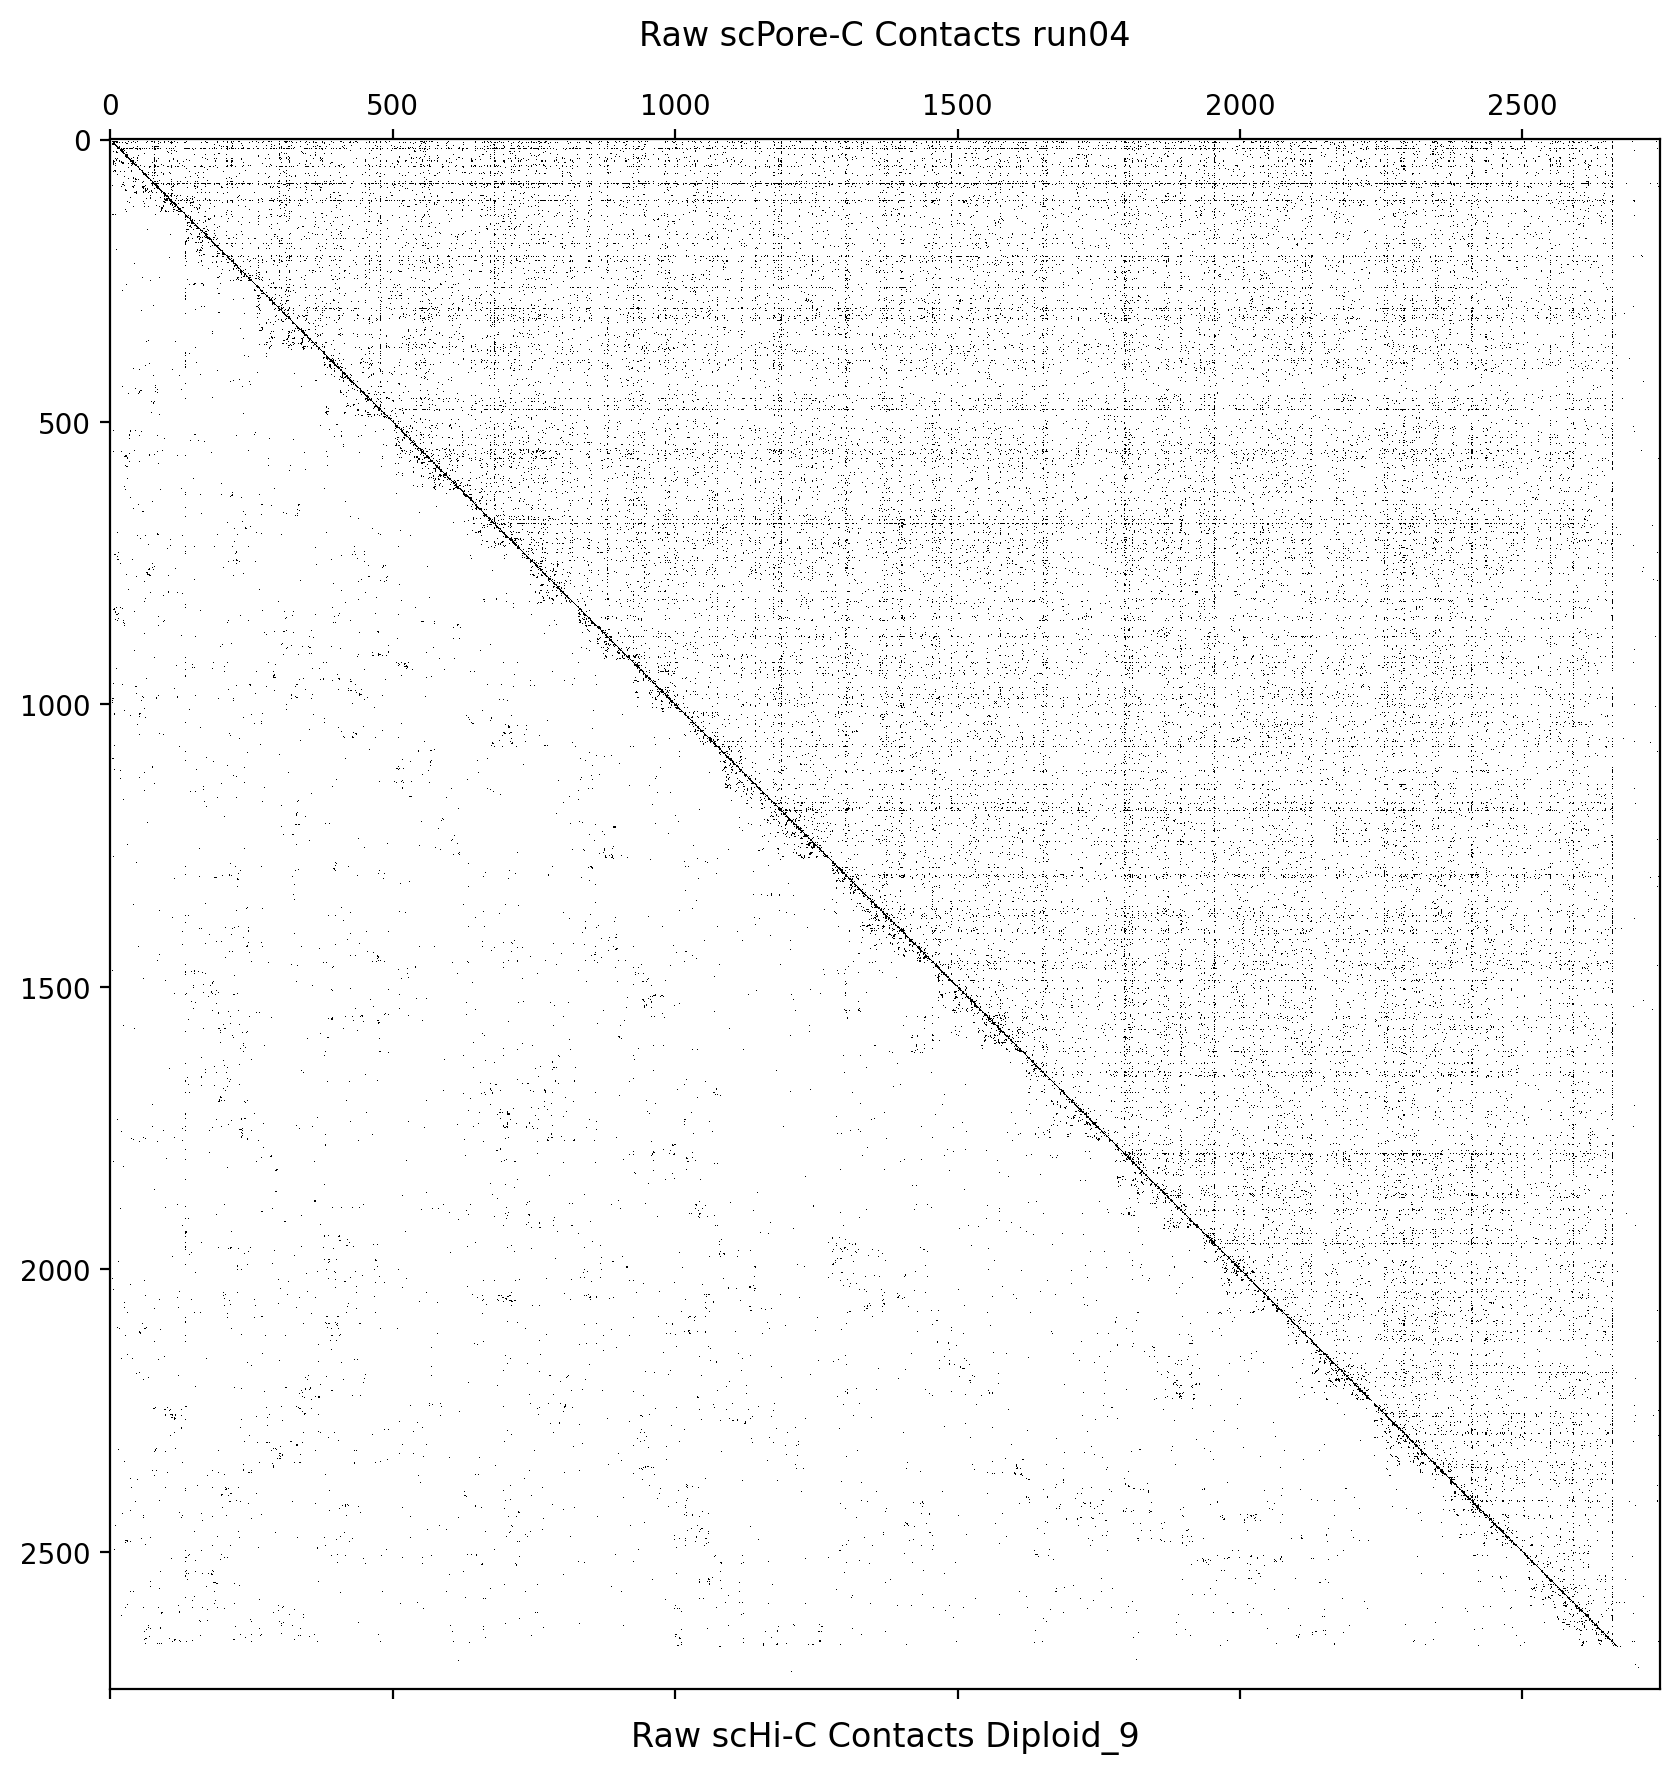

------------------------
pKey='run05'
hKey='Diploid_31'


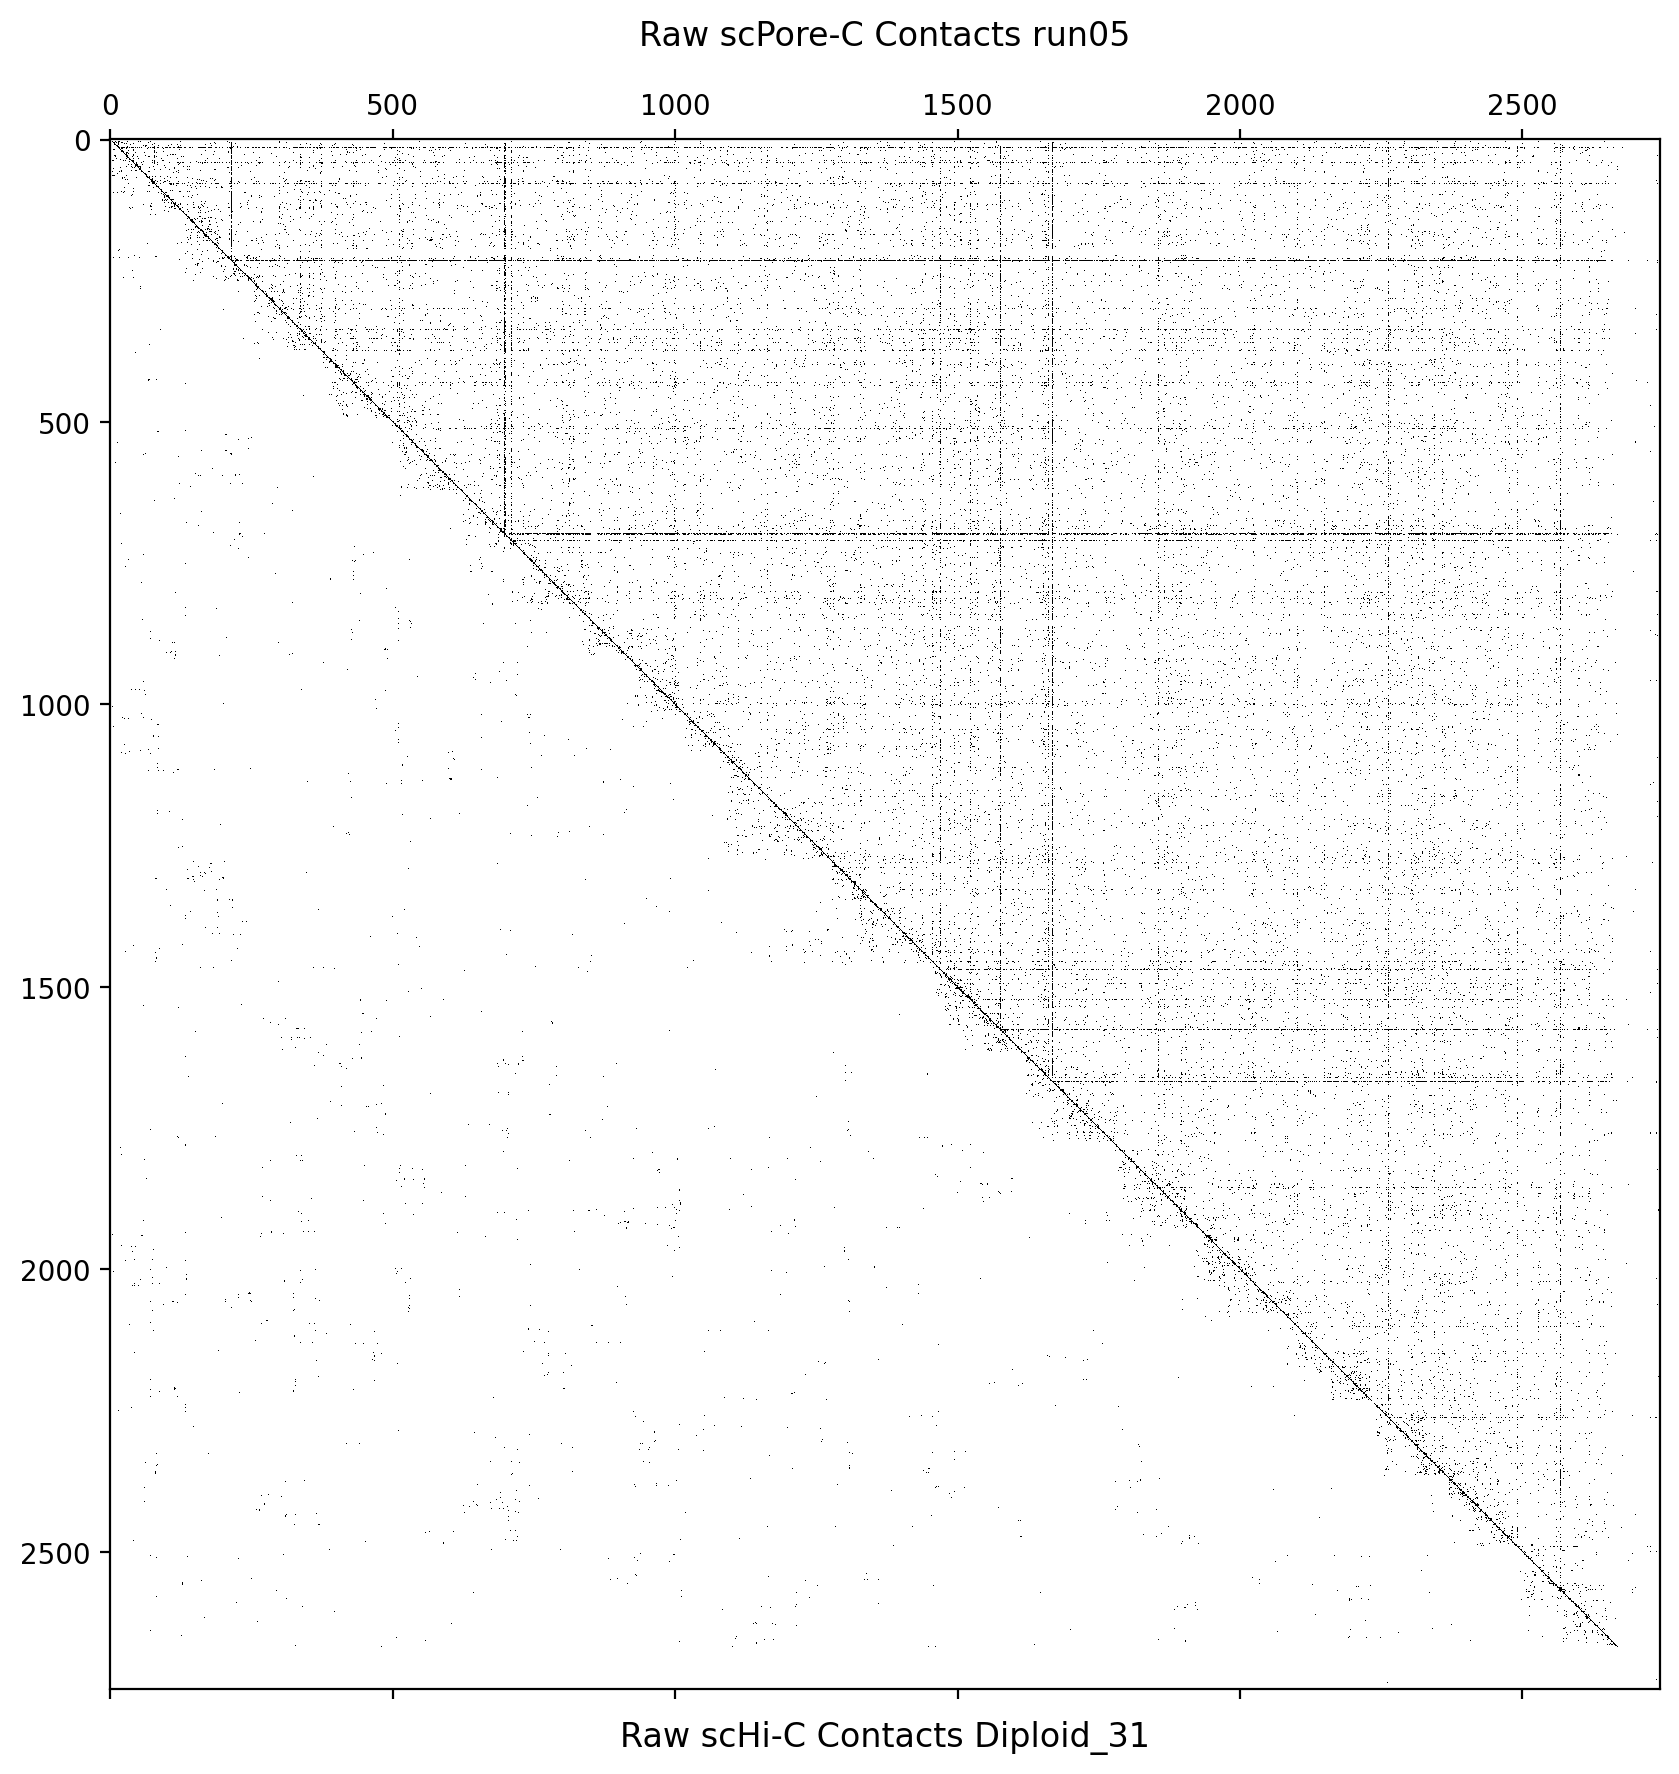

------------------------
pKey='run06'
hKey='Diploid_32'


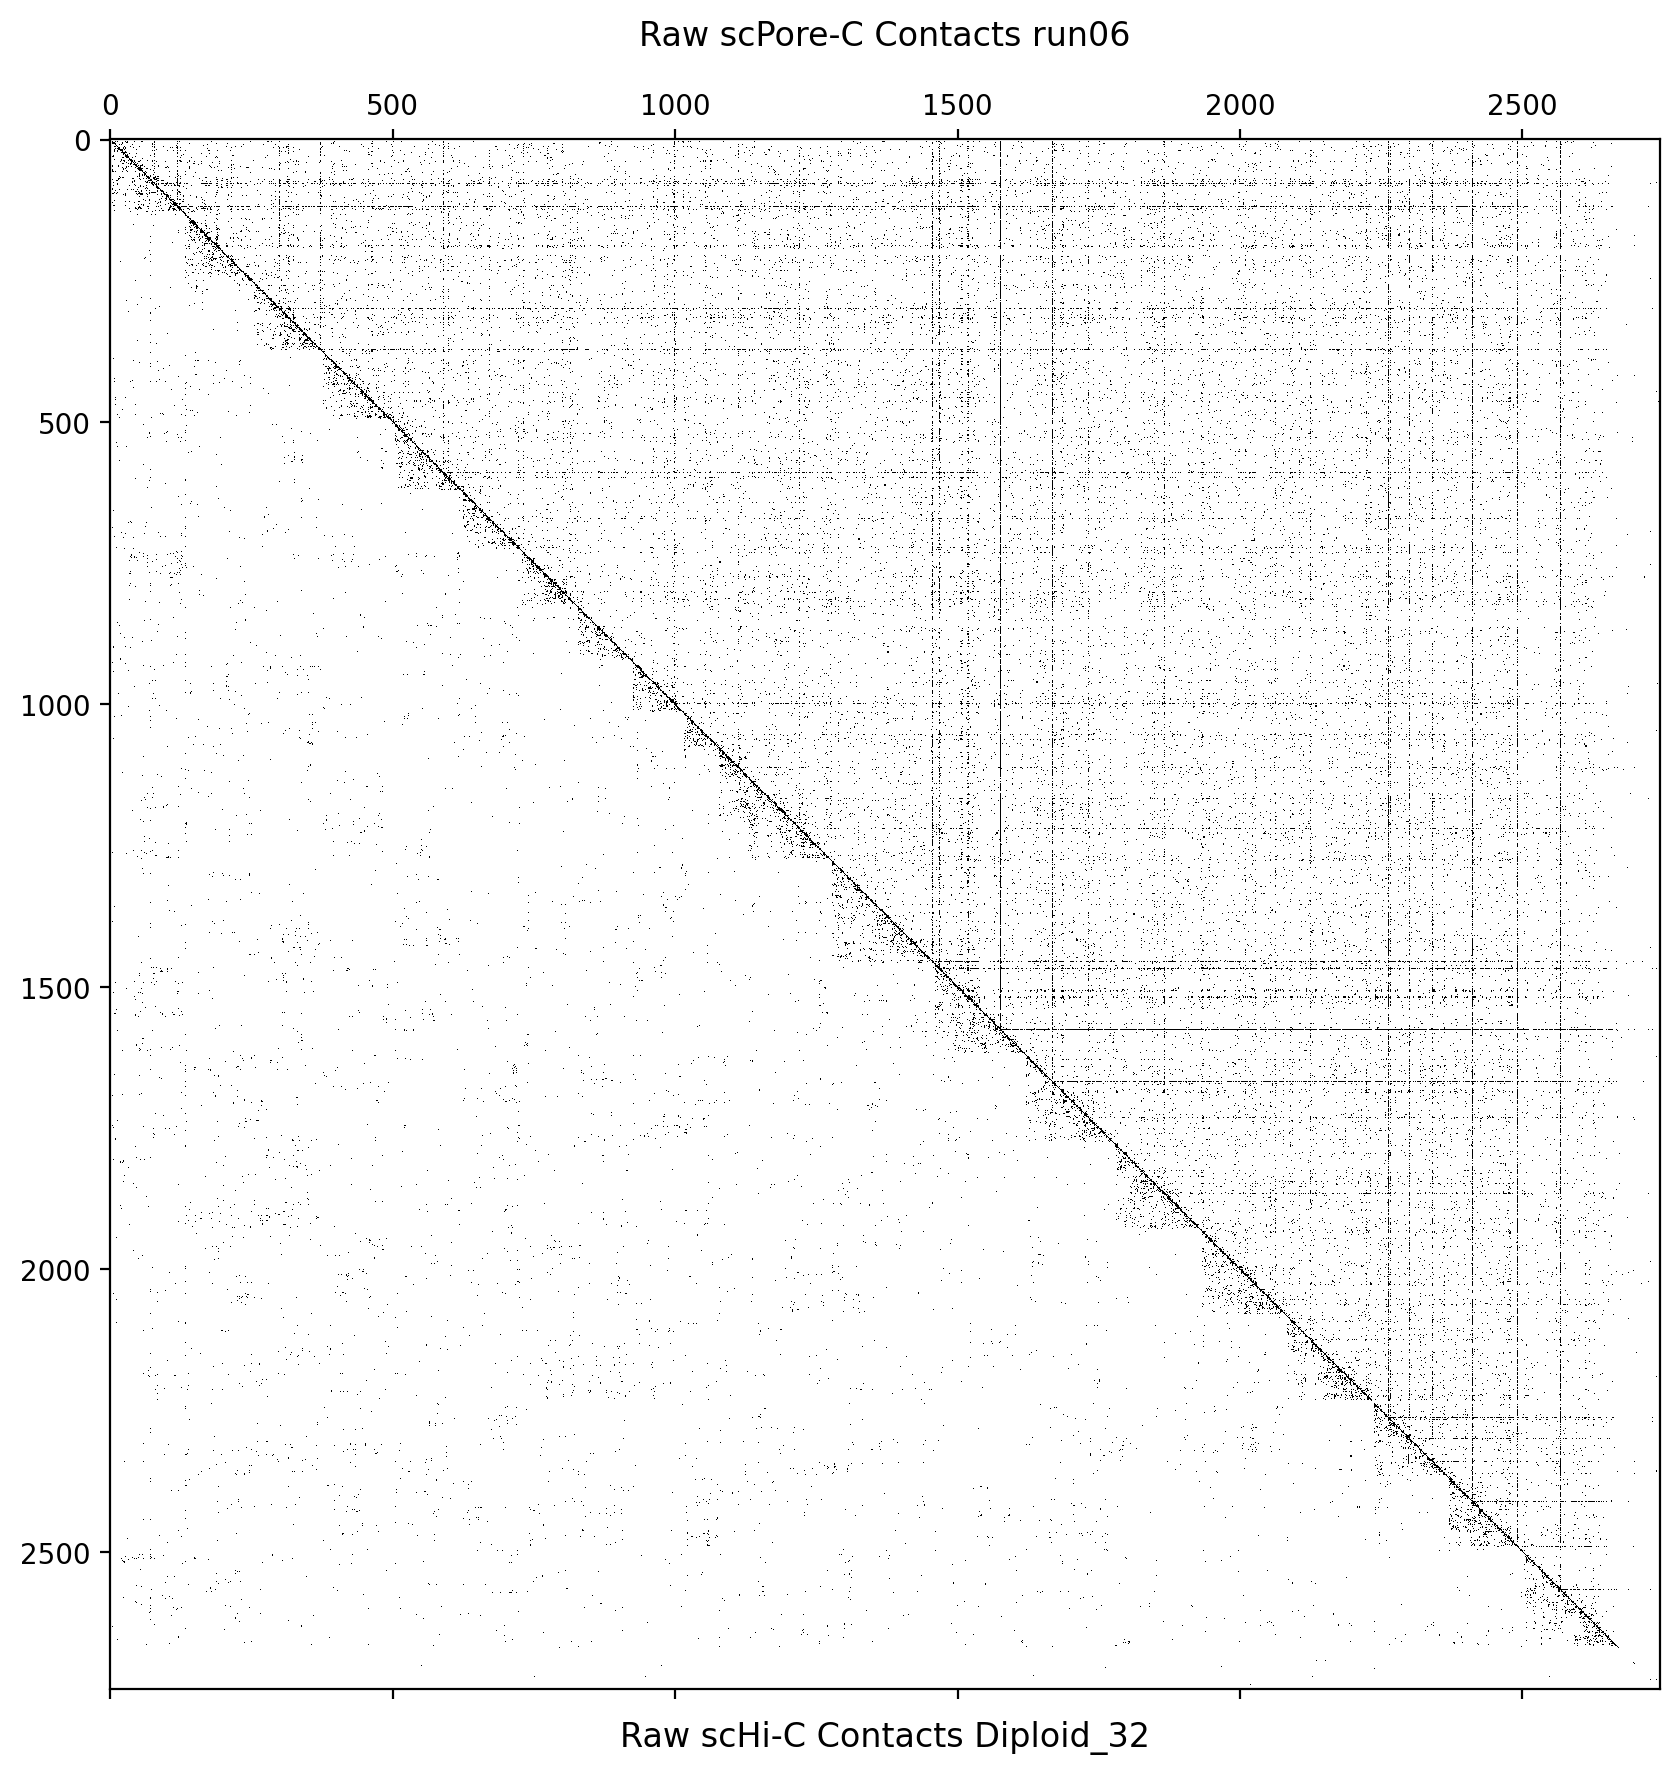

------------------------
pKey='run07'
hKey='Diploid_34'


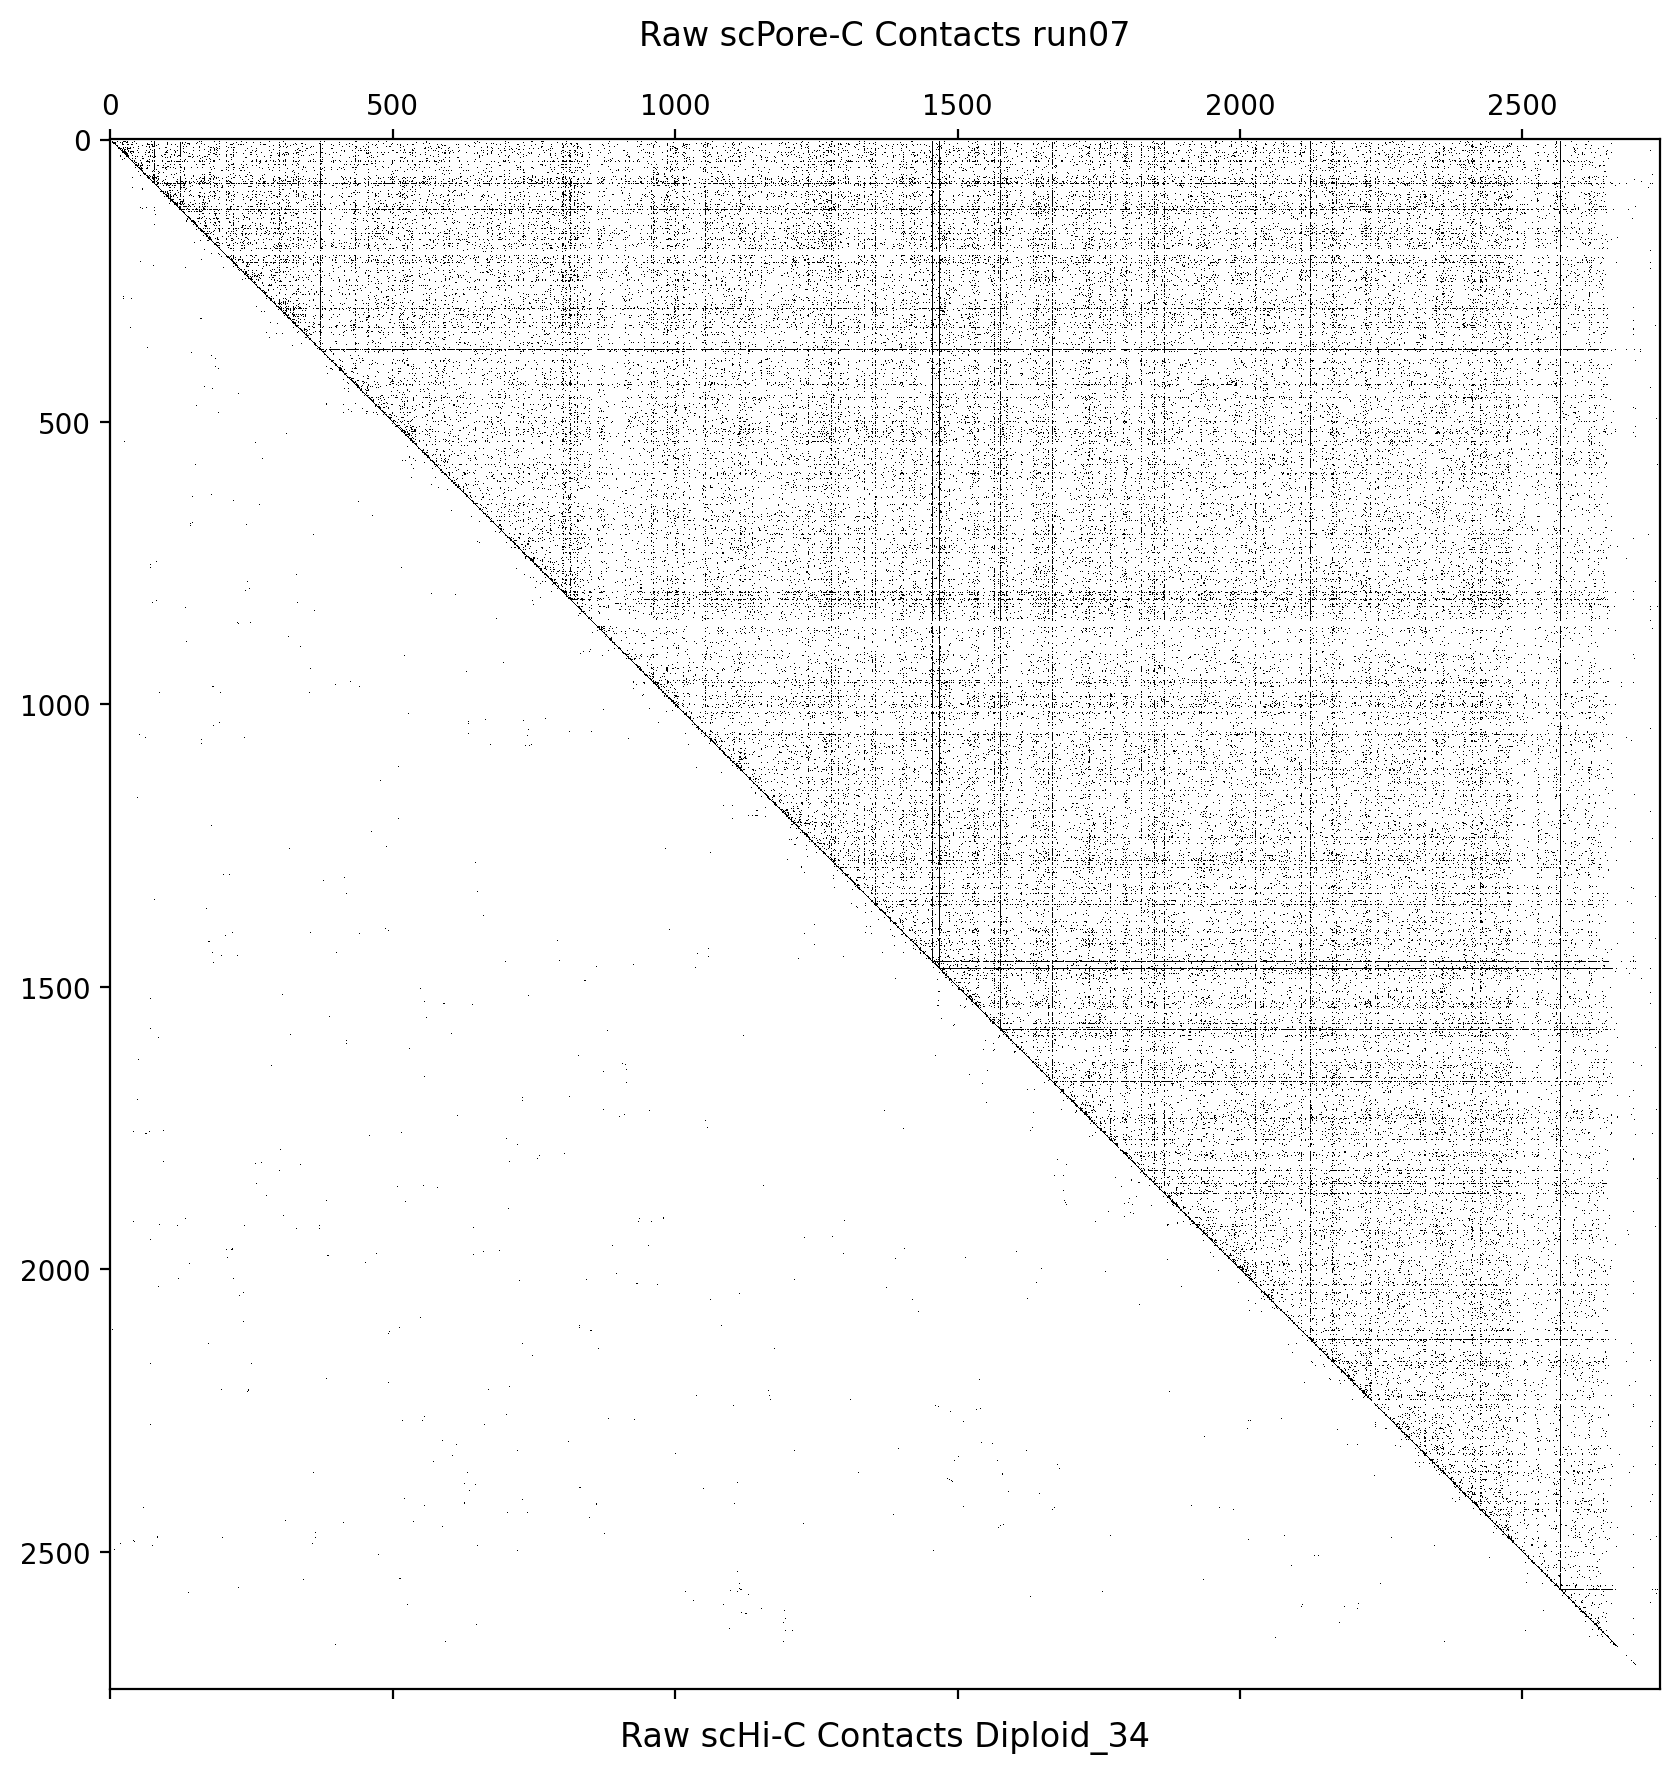

In [8]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 10

zippedKeys = list(zip(poreC.keys(), hiC.keys()))

for pKey, hKey in zippedKeys:
    
    print("------------------------")
    print(f"{pKey=}")
    print(f"{hKey=}")
    pMat = poreC[pKey].matrix(balance=True)[:]
    hMat = hiC[hKey].matrix(balance=True)[:]
    
    # binarize both
    pMatBinary = np.where(pMat > 0, 1, 0)
    hMatBinary = np.where(hMat > 0, 1, 0)
    
    A = np.zeros(hMat.shape)
    
    # truncate the y chrome of the porec data
    n = hMat.shape[0]
    pMatBinary = pMatBinary[0:n, 0:n]
    
    # get upper and lower triangles
    pMatTri = np.triu(pMatBinary)
    hMatTri = np.tril(hMatBinary)
    
    A += pMatTri
    A += hMatTri
    
    ABinary = np.where(A > 0, 1, 0)
    
    plt.matshow(ABinary, cmap='binary')
    plt.title(f'Raw scPore-C Contacts {pKey}')
    plt.text((n//2), n+100, f"Raw scHi-C Contacts {hKey}", 
             horizontalalignment='center', fontsize=12)
    
    
    plt.show()

In [9]:


psuedoPoreC = np.zeros(poreC['run01'].shape)

for k,v in poreC.items():
    psuedoPoreC += v.matrix(balance=True)[:]
    

# kinda hacky
psuedoHiC = np.zeros(hiC[list(hiC.keys())[0]].shape)
    
for k,v in hiC.items():
    psuedoHiC += v.matrix(balance=True)[:]

print(f"{psuedoPoreC.shape=}")
print(f"{psuedoHiC.shape=}")


psuedoPoreC.shape=(2774, 2774)
psuedoHiC.shape=(2744, 2744)


Text(1372, 2844, 'Raw scHi-C Contacts Ensemble')

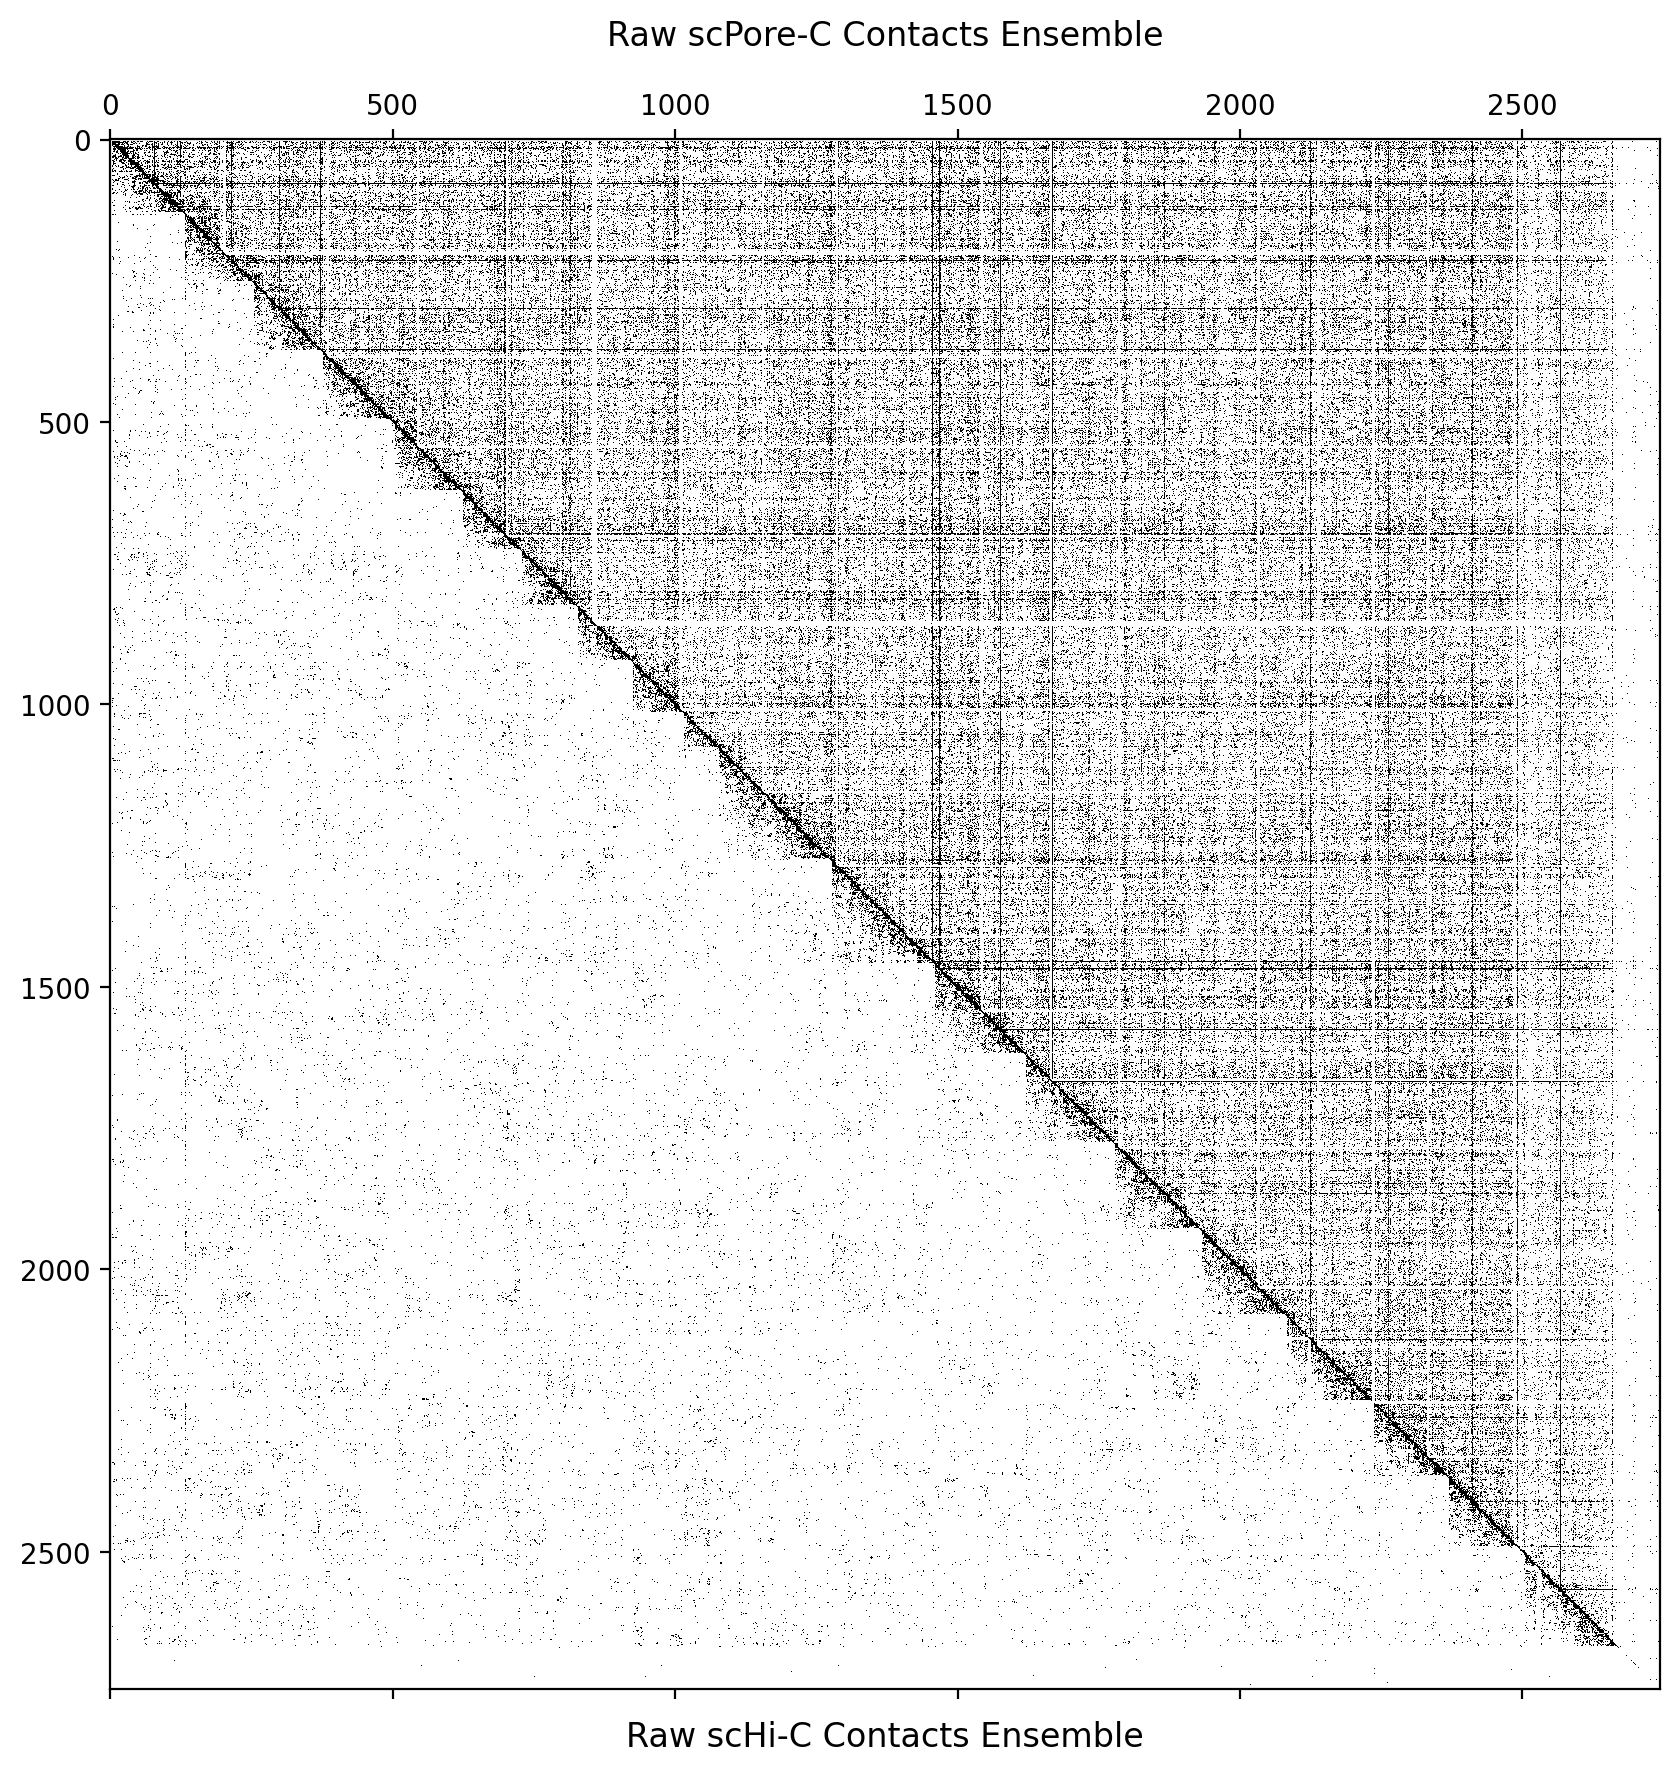

In [10]:
pMatBinary = np.where(psuedoPoreC > 0, 1, 0)
hMatBinary = np.where(psuedoHiC > 0, 1, 0)

A = np.zeros(psuedoHiC.shape)

# truncate the y chrome of the porec data
n = psuedoHiC.shape[0]
pMatBinary = pMatBinary[0:n, 0:n]

# get upper and lower triangles
pMatTri = np.triu(pMatBinary)
hMatTri = np.tril(hMatBinary)

A += pMatTri
A += hMatTri

ABinary = np.where(A > 0, 1, 0)

plt.matshow(ABinary, cmap='binary')
plt.title(f'Raw scPore-C Contacts Ensemble')
plt.text((n//2), n+100, f"Raw scHi-C Contacts Ensemble", 
         horizontalalignment='center', fontsize=12)


------------------------
pKey='run01'
hKey='Diploid_10'
(182, 182)
(182, 182)


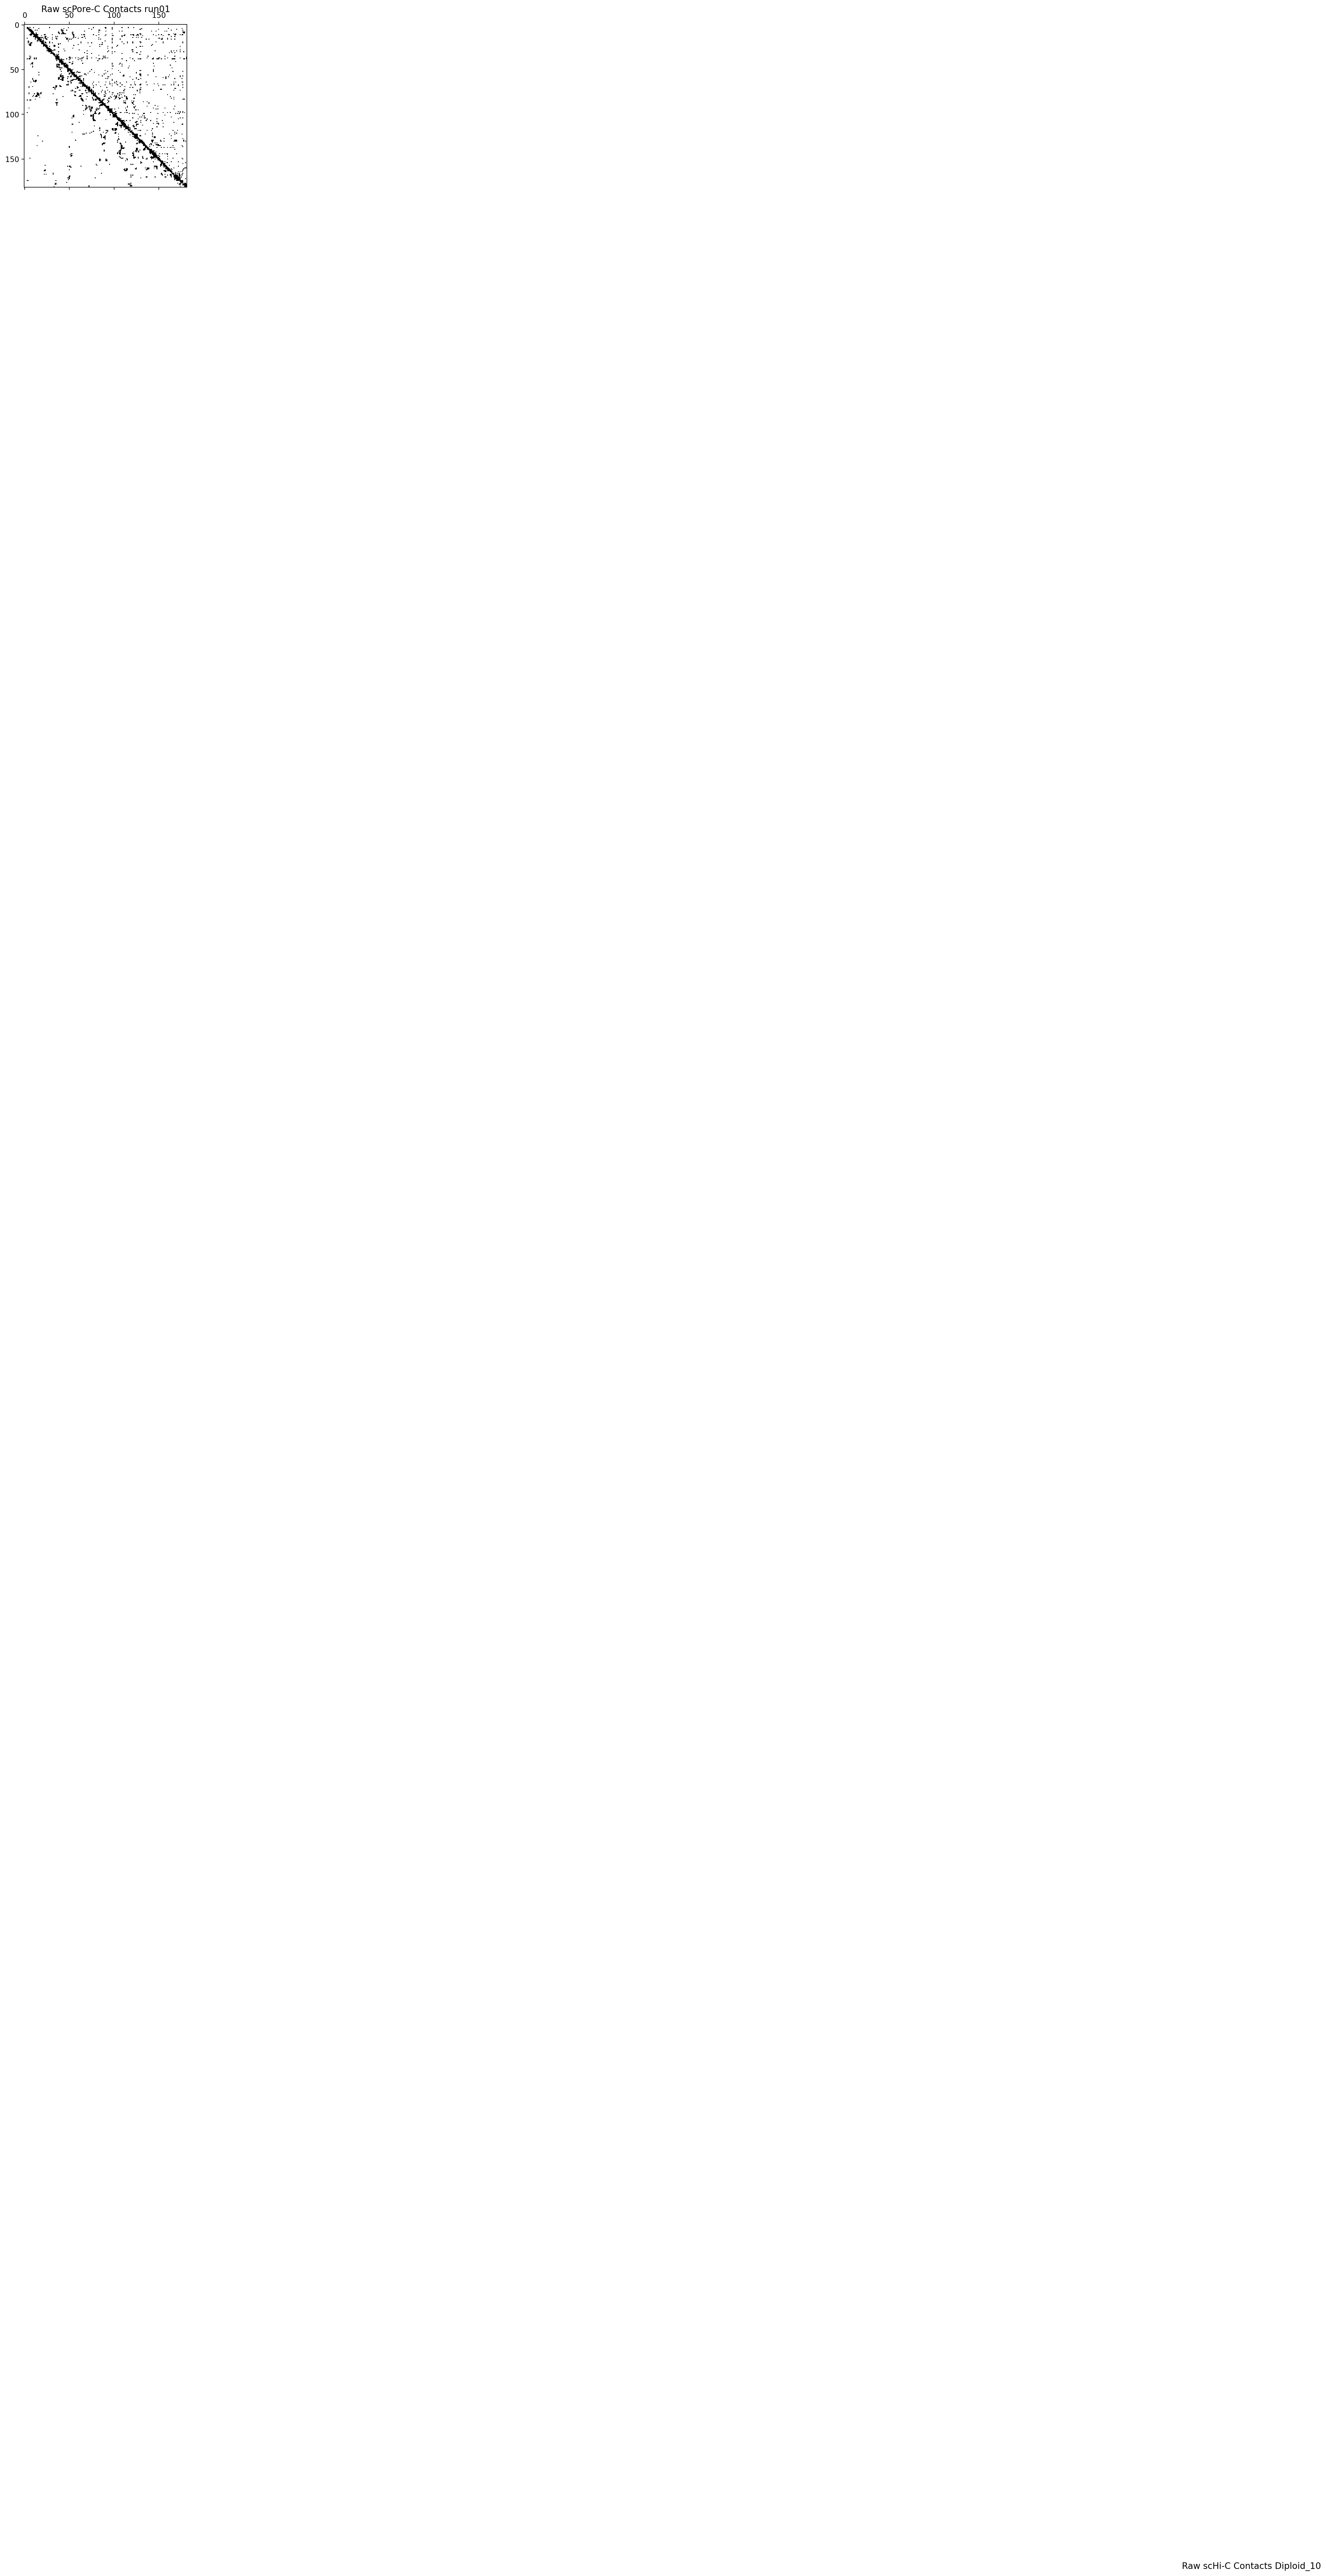

In [14]:
plt.close()
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

# chromosome 2
zippedKeys = list(zip(poreC.keys(), hiC.keys()))

for pKey, hKey in zippedKeys:
    
    print("------------------------")
    print(f"{pKey=}")
    print(f"{hKey=}")
    pMat = poreC[pKey].matrix(balance=True).fetch('NC_000068.8')[:]
    hMat = hiC[hKey].matrix(balance=True).fetch('chr2')[:]
    
    print(f"{pMat.shape}")
    print(f"{hMat.shape}")
    
    
    # binarize both
    pMatBinary = np.where(pMat > 0, 1, 0)
    hMatBinary = np.where(hMat > 0, 1, 0)
    
    # get upper and lower triangles
    pMatTri = np.triu(pMatBinary)
    hMatTri = np.tril(hMatBinary)
    
    A = np.zeros(pMat.shape)
    
    A += pMatTri
    A += hMatTri
    
    ABinary = np.where(A > 0, 1, 0)
    
    plt.matshow(ABinary, cmap='binary')
    plt.title(f'Raw scPore-C Contacts {pKey}')
    plt.text((n//2), n+100, f"Raw scHi-C Contacts {hKey}", 
             horizontalalignment='center', fontsize=12)
    
    plt.show()
    
    break

In [12]:
# A = np.zeros(psuedoHiC.shape)

# # truncate the y chrome of the porec data
# n = psuedoHiC.shape[0]
# psuedoPoreC = psuedoPoreC[0:n, 0:n]

# # get upper and lower triangles
# pMatTri = np.triu(psuedoPoreC)
# hMatTri = np.tril(psuedoHiC)

# A += pMatTri
# A += hMatTri

# plt.matshow(A, cmap='Reds')
# plt.title(f'Raw scPore-C Contacts Ensemble')
# plt.text((n//2), n+100, f"Raw scHi-C Contacts Ensemble", 
#          horizontalalignment='center', fontsize=12)